In [1]:
!pip install opendatasets

In [5]:
if torch.cuda.is_available():
  print ('cuda')
  device= torch.device('cuda')
else:
  print ('cpu')
  device= torch.device('cpu')


cuda


In [6]:
import opendatasets as od
od.download ('https://www.kaggle.com/datasets/zalando-research/fashionmnist', data_dir= '/content/sample_data')

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.14GB/s]

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df= pd.read_csv ('/content/sample_data/fashionmnist/fashion-mnist_train.csv')

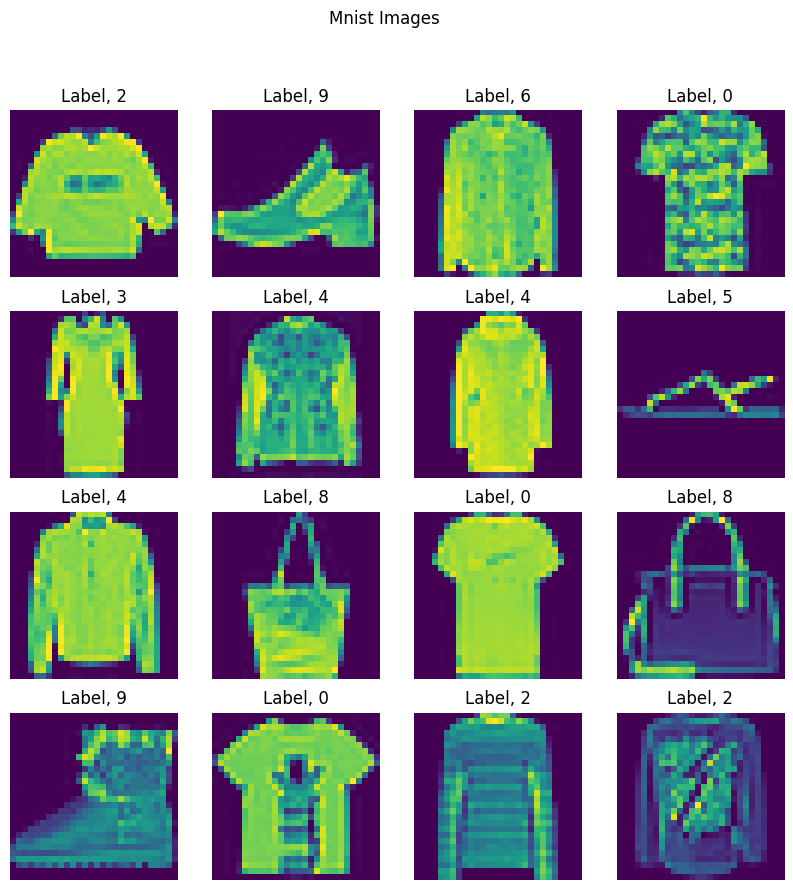

In [8]:
## 4*4 grid of images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
fig.suptitle ('Mnist Images')

#plot 16 images
for i, ax in enumerate(axes.flat):
  ax.imshow(np.array(df.iloc[i,1:]).reshape(28,28))
  ax.axis('off')
  ax.set_title(f'Label, {df.iloc[i,0]}')
plt.show()

In [9]:
X_train= df.iloc[:,1:].values
y_train= df.iloc[:,0].values
X_train= X_train/255.0

df2= pd.read_csv ('/content/sample_data/fashionmnist/fashion-mnist_test.csv')
X_test= df2.iloc[:,1:].values
y_test= df2.iloc[:,0].values
X_test= X_test/255.0

In [10]:
## custom dataset
class FashionDataset(Dataset):
  def __init__ (self, features, labels):
    self.features= torch.tensor ( features, dtype= torch.float32)
    self.labels= torch.tensor (labels, dtype= torch.long)

  def __len__ (self):
    return len(self.features)

  def __getitem__ (self, index):
    return self.features[index], self.labels[index]

In [11]:
train_dataset= FashionDataset(X_train, y_train)
test_dataset= FashionDataset(X_test, y_test)


In [28]:
class mnist (nn.Module):
  def __init__ (self, input_dim, output_dim, hidden_layers_neurons, dropouts):
    super().__init__()
    layers=[]
    current_input_dim= input_dim
    for neurons_in_layer in hidden_layers_neurons:
      layers.append (nn.Linear(current_input_dim, neurons_in_layer))
      layers.append (nn.BatchNorm1d (neurons_in_layer))
      layers.append (nn.ReLU())
      layers.append (nn.Dropout(dropouts))
      current_input_dim = neurons_in_layer
    layers.append (nn.Linear(current_input_dim, output_dim))
    self.model= nn.Sequential (*layers)

  def forward (self, x):
    return self.model (x)

In [37]:
#Objective function


def objective (trial):

  num_hidden_layers= trial.suggest_int( 'num_hidden_layers', 1,9)
  # Suggest the number of neurons for each hidden layer
  hidden_layers_neurons = [trial.suggest_int(f'neurons_layer_{i}', 8, 128, step=8) for i in range(num_hidden_layers)]

  dropouts= trial.suggest_float ('dropouts', 0.1, 0.5)
  epochs= trial.suggest_int ('epochs', 10,50, step=10)
  learning_rate= trial.suggest_float ('learning_rate', 1e-5, 1e-1, log=True)
  batch_size= trial.suggest_categorical ('batch_size', [32,64,128])
  optimizer_name = trial.suggest_categorical ('optimizer', ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float ('weight_decay', 1e-4,1e-2, log=True)

  train_dataloader= DataLoader( train_dataset, batch_size=batch_size, shuffle= True, pin_memory= True)
  test_dataloader = DataLoader (test_dataset, batch_size=batch_size, shuffle= False, pin_memory= True)


  input_dim = 784
  output_dim =10

  # Pass the list of neuron counts to the mnist class
  model= mnist (input_dim, output_dim, hidden_layers_neurons, dropouts)
  model.to(device)

  if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optimizer= optim.SGD(model.parameters (), lr= learning_rate, weight_decay = weight_decay)
  else:
    optimizer= optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  criterion= nn.CrossEntropyLoss()

  #training loop

  for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for batch_features, batch_labels in train_dataloader:
      batch_features = batch_features.to(device)
      batch_labels= batch_labels.to(device) # Corrected to device

      #forward pass
      outputs= model(batch_features)

      #loss
      loss= criterion(outputs, batch_labels)

      #backward pass
      optimizer.zero_grad() # Corrected from zero.grad()
      loss.backward()

      # update grads
      optimizer.step()
      running_loss += loss.item() * batch_features.size(0)
    epoch_loss = running_loss / len(train_dataset)
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}") # Optional: print epoch loss


  model.eval()

  ##evaluation
  correct=0
  total=0
  with torch.no_grad(): # Add no_grad() for evaluation
    for batch_features, batch_labels in test_dataloader: # Changed to test_dataloader
      batch_features, batch_labels= batch_features.to(device), batch_labels.to(device)

      outputs= model(batch_features)

      _, predicted= torch.max(outputs.data,1)

      total= total + batch_labels.shape[0] # Corrected from batch_labels,shape[0]

      correct= correct + (predicted == batch_labels).sum().item() # Corrected from .items()

  Accuracy = correct/total
  print ('='*50)
  print ('Model Succesfully created')
  print ('='*50)
  print ('Model Started')
  return Accuracy
  print (f'Accuracy: {Accuracy}')

In [23]:
!pip install optuna

In [38]:
## Optuna Study Creation
import optuna
study= optuna.create_study (direction='maximize')
study.optimize (objective, n_trials =4)

[I 2025-08-24 02:57:28,990] A new study created in memory with name: no-name-49a2f4f8-5952-4707-af98-7ff4b094270c
[I 2025-08-24 03:00:13,508] Trial 0 finished with value: 0.1 and parameters: {'num_hidden_layers': 7, 'neurons_layer_0': 40, 'neurons_layer_1': 16, 'neurons_layer_2': 24, 'neurons_layer_3': 32, 'neurons_layer_4': 80, 'neurons_layer_5': 88, 'neurons_layer_6': 120, 'dropouts': 0.226513038367645, 'epochs': 30, 'learning_rate': 0.0579545956885719, 'batch_size': 64, 'optimizer': 'RMSprop', 'weight_decay': 0.003410413859684342}. Best is trial 0 with value: 0.1.


Model Succesfully created
Model Started


[I 2025-08-24 03:02:13,543] Trial 1 finished with value: 0.8617 and parameters: {'num_hidden_layers': 5, 'neurons_layer_0': 96, 'neurons_layer_1': 40, 'neurons_layer_2': 64, 'neurons_layer_3': 112, 'neurons_layer_4': 104, 'dropouts': 0.3904248578601134, 'epochs': 40, 'learning_rate': 0.001794523824156612, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 0.00020584092469332643}. Best is trial 1 with value: 0.8617.


Model Succesfully created
Model Started


[I 2025-08-24 03:05:28,760] Trial 2 finished with value: 0.5151 and parameters: {'num_hidden_layers': 9, 'neurons_layer_0': 64, 'neurons_layer_1': 48, 'neurons_layer_2': 64, 'neurons_layer_3': 56, 'neurons_layer_4': 16, 'neurons_layer_5': 104, 'neurons_layer_6': 88, 'neurons_layer_7': 88, 'neurons_layer_8': 96, 'dropouts': 0.3550551389740628, 'epochs': 50, 'learning_rate': 0.005570379414703264, 'batch_size': 128, 'optimizer': 'Adam', 'weight_decay': 0.007298988158136008}. Best is trial 1 with value: 0.8617.


Model Succesfully created
Model Started


[I 2025-08-24 03:07:53,378] Trial 3 finished with value: 0.7892 and parameters: {'num_hidden_layers': 5, 'neurons_layer_0': 96, 'neurons_layer_1': 8, 'neurons_layer_2': 104, 'neurons_layer_3': 72, 'neurons_layer_4': 32, 'dropouts': 0.3503471559818837, 'epochs': 30, 'learning_rate': 0.00045203044243381937, 'batch_size': 64, 'optimizer': 'Adam', 'weight_decay': 0.00027640541438291895}. Best is trial 1 with value: 0.8617.


Model Succesfully created
Model Started


In [39]:
study.best_value

0.8617

In [40]:
study.best_params

{'num_hidden_layers': 5,
 'neurons_layer_0': 96,
 'neurons_layer_1': 40,
 'neurons_layer_2': 64,
 'neurons_layer_3': 112,
 'neurons_layer_4': 104,
 'dropouts': 0.3904248578601134,
 'epochs': 40,
 'learning_rate': 0.001794523824156612,
 'batch_size': 128,
 'optimizer': 'RMSprop',
 'weight_decay': 0.00020584092469332643}